In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def keypoint_match(img, img2):
    
    #find key points using SIFT
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    # create BFMatcher object
    bf = cv2.BFMatcher()
    # Match descriptors.
    matches = bf.match(des1,des2)
    print(len(matches))
    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    # Draw first 10 matches.
    img3 = cv2.drawMatches(img,kp1,img2,kp2,matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img3)
    plt.title("First 10 matches")
    plt.axis('off')
#     plt.savefig('keypoint_match', bbox_inches='tight', pad_inches=0)
    plt.show()
    
    np.random.shuffle(matches)
    img3 = cv2.drawMatches(img,kp1,img2,kp2,matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img3)
    plt.title("Random 10 matches")
    plt.axis('off')
#     plt.savefig('random_keypoint_match', bbox_inches='tight', pad_inches=0)
    plt.show()
    
    return kp1,kp2,matches
    


In [32]:
import random
from matplotlib.patches import ConnectionPatch

def construct_matches(kp1, kp2, matches):

    match_kp1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    match_kp2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    print(match_kp1)
    print(match_kp1.shape)
#     print(b)
    return match_kp1, match_kp2
    
def find_transformation(kp1, kp2):
    length = kp1.shape[0]
    A = np.zeros((2*length, 6))
    b = np.zeros((2*length, 1))
    for i in range(length):
        A[2*i] = [kp1[i,0], kp1[i,1], 0, 0, 1, 0]
        A[2*i + 1] = [0, 0, kp1[i,0], kp1[i,1], 0, 1]
        b[2*i] = [kp2[i,0]]
        b[2*i + 1] = [kp2[i,1]]
    print("b shape:{}".format(b.shape))
    A_pinv = np.linalg.pinv(A)
    x = np.matmul(A_pinv, b)
    return x, A, b

def RANSAC(matches, kp1, kp2, p, threshold, n, img1, img2):
    match_kp1, match_kp2 = construct_matches(kp1, kp2, matches)
    
    inlier_count = 0
    best_inlier_count = 0
    best_x = None
    for i in range(n):
        print("--- iter_num:{}/{}---".format(i, n))
        index = np.random.randint(0, len(matches), p)
        sample1 = match_kp1[index,0]
        sample2 = match_kp2[index,0]
        computed_kp2 = np.array([]).reshape((0,2))
        x, A, b = find_transformation(sample1, sample2)
        # judge the score
        for j in range(len(A)//2):
            point1 = np.array([A[j], A[j+1]])
            point2 = np.array([b[j], b[j+1]])
            transformated_point = np.matmul(point1, x).reshape(2,1)
            computed_kp2 = np.vstack((computed_kp2, transformated_point.T))
                  
            distance = np.linalg.norm(point2 - transformated_point)
#             print(distance)
            if distance < threshold:
                  inlier_count += 1
    
        if inlier_count > best_inlier_count:
            best_inlier_count = inlier_count
            best_x = x
            
            #Display a set of key points detected, linked the match between the query and training image
            fig = plt.figure(1, figsize=(8, 14), frameon=False, dpi=100)
            
            ax1 = fig.add_subplot(121)
            ax2 = fig.add_subplot(122)
            ax1.imshow(img1, cmap='gray')
            ax1.set_title('Image 1')
            ax1.axis('off')
            ax2.imshow(img2, cmap='gray')
            ax2.set_title('Image 2')
            ax2.axis('off')
            for k in range(len(sample1)):
                con = ConnectionPatch(
                xyA = sample1[k, :], coordsA = ax1.transData,
                xyB = computed_kp2[k, :], coordsB = ax2.transData,
                arrowstyle = "->",
                shrinkB =5
                )
                con.set_color('green')
                con.set_linewidth(1)
                fig.add_artist(con)
            ax1.scatter(sample1[:, 0], sample1[:, 1], color='blue')
            ax2.scatter(computed_kp2[:, 0], computed_kp2[:, 1], color='red')
            plt.savefig('transformated_image1_to_image2', bbox_inches='tight', pad_inches=0)
            plt.show()
            print('---Best inlier at iteration:{} Best count:{}---'.format(i, best_inlier_count))
    if best_inlier_count == 0 :
        print(f"Could not find a good model inliers found is {best_inlier_count}. Try again with various P (P is now set to {p})!")
        exit()
    return best_x
    
def transform_image(img, img2, x):
    h, w = img.shape
    h2, w2 = img2.shape
    m = np.array([
        [x[0,0], x[1,0]],
        [x[2,0], x[3,0]]
    ])
    print("m:{}".format(m))
    t = np.array([[x[4,0]], [x[5,0]]])
    print(t.shape)
    
    # Nearest-neighbor method
    m_pinv = np.linalg.pinv(m)
    
    transformed_img1 = np.zeros((h2, w2))
    transformed_img2 = np.zeros((h, w))
    for x1 in range(w):
        for y1 in range(h):
            transformed = np.matmul(m, [x1, y1]).reshape(2, 1) + t
            # nearest-neighbor interpolation
            i, j = np.rint(transformed).astype(int)
            if 0 <= i < w2 and 0 <= j < h2:
                transformed_img1[j, i] = img[y1, x1]
    
    for x2 in range(w2):
        for y2 in range(h2):
            img_t = np.array([x2, y2]).reshape(2,1) - t
            transformed = np.matmul(m_pinv, img_t).reshape(2, 1)
            i2, j2 = np.rint(transformed).astype(int)
            if 0 <= i2 < w and 0 <= j2 < h:
                transformed_img2[j2, i2] = img2[y2, x2]
    
    fig = plt.figure()
    ax1=fig.add_subplot(221)
    ax1.imshow(img, cmap="gray")
    ax1.axis("off")
    ax1.set_title("Image1")
    ax2=fig.add_subplot(222)
    ax2.imshow(img2, cmap="gray")
    ax2.axis("off")
    ax2.set_title("Image2")
    ax3=fig.add_subplot(223)
    ax3.imshow(transformed_img2, cmap="gray")
    ax3.axis("off")
    ax3.set_title("Image 2 to image 1")
    ax4=fig.add_subplot(224)
    ax4.imshow(transformed_img1, cmap="gray")
    ax4.axis("off")
    ax4.set_title("Image 1 to image 2")
    plt.savefig('nearest_neighbor', bbox_inches='tight', pad_inches=0)
    plt.show()
    
    
    # opencv method
    m_ = np.array([
        [x[0], x[1], x[4]],
        [x[2], x[3], x[5]]
    ])
    print(m_)
    warp = cv2.warpAffine(img, m_, (w2, h2))              
    cv2.imwrite("warpaffine_1_2_2.jpg", warp)
    
    m_inv = np.linalg.inv(m)
    t = (-1*t)
    t = np.matmul(m_inv, t).reshape(2,1)
    m2 = np.concatenate((m_inv, t), axis=1)
    
    warp2 = cv2.warpAffine(img2, m2, (w,h))
    cv2.imwrite("warpaffine_2_1_2.jpg", warp2)


8849


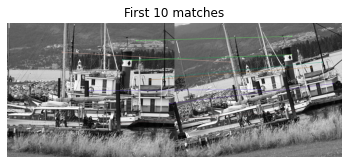

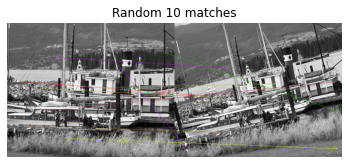

[[[618.7068   383.3322  ]]

 [[172.48683  331.45306 ]]

 [[575.36426  227.87955 ]]

 ...

 [[269.3093   117.652   ]]

 [[112.375755 564.0522  ]]

 [[465.10416  409.81006 ]]]
(8849, 1, 2)
--- iter_num:0/100---
b shape:(20, 1)
--- iter_num:1/100---
b shape:(20, 1)
--- iter_num:2/100---
b shape:(20, 1)
--- iter_num:3/100---
b shape:(20, 1)
--- iter_num:4/100---
b shape:(20, 1)
--- iter_num:5/100---
b shape:(20, 1)
--- iter_num:6/100---
b shape:(20, 1)
--- iter_num:7/100---
b shape:(20, 1)
--- iter_num:8/100---
b shape:(20, 1)
--- iter_num:9/100---
b shape:(20, 1)
--- iter_num:10/100---
b shape:(20, 1)
--- iter_num:11/100---
b shape:(20, 1)
--- iter_num:12/100---
b shape:(20, 1)
--- iter_num:13/100---
b shape:(20, 1)
--- iter_num:14/100---
b shape:(20, 1)
--- iter_num:15/100---
b shape:(20, 1)
--- iter_num:16/100---
b shape:(20, 1)
--- iter_num:17/100---
b shape:(20, 1)
--- iter_num:18/100---
b shape:(20, 1)
--- iter_num:19/100---
b shape:(20, 1)
--- iter_num:20/100---
b shape:(20, 1)
--- 

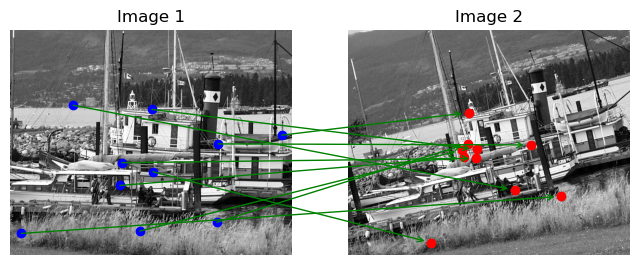

---Best inlier at iteration:40 Best count:1---
--- iter_num:41/100---
b shape:(20, 1)


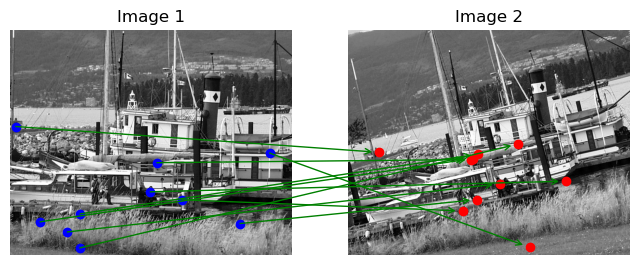

---Best inlier at iteration:41 Best count:2---
--- iter_num:42/100---
b shape:(20, 1)
--- iter_num:43/100---
b shape:(20, 1)
--- iter_num:44/100---
b shape:(20, 1)
--- iter_num:45/100---
b shape:(20, 1)
--- iter_num:46/100---
b shape:(20, 1)
--- iter_num:47/100---
b shape:(20, 1)
--- iter_num:48/100---
b shape:(20, 1)
--- iter_num:49/100---
b shape:(20, 1)
--- iter_num:50/100---
b shape:(20, 1)
--- iter_num:51/100---
b shape:(20, 1)
--- iter_num:52/100---
b shape:(20, 1)
--- iter_num:53/100---
b shape:(20, 1)
--- iter_num:54/100---
b shape:(20, 1)
--- iter_num:55/100---
b shape:(20, 1)
--- iter_num:56/100---
b shape:(20, 1)
--- iter_num:57/100---
b shape:(20, 1)
--- iter_num:58/100---
b shape:(20, 1)
--- iter_num:59/100---
b shape:(20, 1)


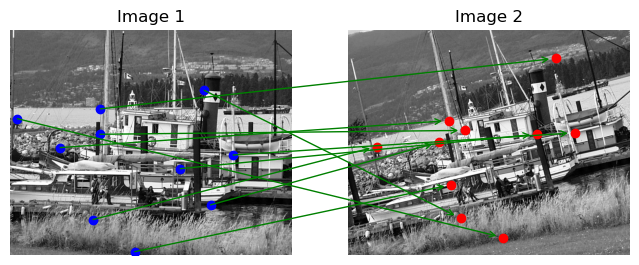

---Best inlier at iteration:59 Best count:6---
--- iter_num:60/100---
b shape:(20, 1)
--- iter_num:61/100---
b shape:(20, 1)
--- iter_num:62/100---
b shape:(20, 1)
--- iter_num:63/100---
b shape:(20, 1)
--- iter_num:64/100---
b shape:(20, 1)
--- iter_num:65/100---
b shape:(20, 1)
--- iter_num:66/100---
b shape:(20, 1)
--- iter_num:67/100---
b shape:(20, 1)
--- iter_num:68/100---
b shape:(20, 1)
--- iter_num:69/100---
b shape:(20, 1)
--- iter_num:70/100---
b shape:(20, 1)


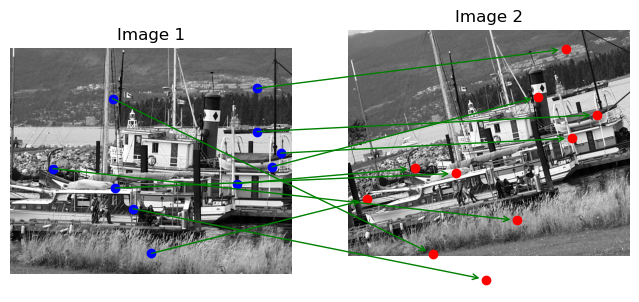

---Best inlier at iteration:70 Best count:9---
--- iter_num:71/100---
b shape:(20, 1)
--- iter_num:72/100---
b shape:(20, 1)
--- iter_num:73/100---
b shape:(20, 1)
--- iter_num:74/100---
b shape:(20, 1)


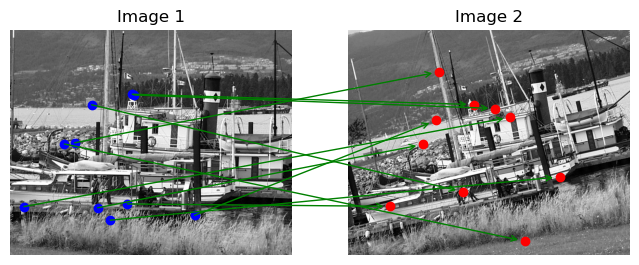

---Best inlier at iteration:74 Best count:10---
--- iter_num:75/100---
b shape:(20, 1)
--- iter_num:76/100---
b shape:(20, 1)
--- iter_num:77/100---
b shape:(20, 1)
--- iter_num:78/100---
b shape:(20, 1)
--- iter_num:79/100---
b shape:(20, 1)
--- iter_num:80/100---
b shape:(20, 1)
--- iter_num:81/100---
b shape:(20, 1)
--- iter_num:82/100---
b shape:(20, 1)
--- iter_num:83/100---
b shape:(20, 1)
--- iter_num:84/100---
b shape:(20, 1)
--- iter_num:85/100---
b shape:(20, 1)
--- iter_num:86/100---
b shape:(20, 1)
--- iter_num:87/100---
b shape:(20, 1)
--- iter_num:88/100---
b shape:(20, 1)
--- iter_num:89/100---
b shape:(20, 1)
--- iter_num:90/100---
b shape:(20, 1)
--- iter_num:91/100---
b shape:(20, 1)
--- iter_num:92/100---
b shape:(20, 1)
--- iter_num:93/100---
b shape:(20, 1)
--- iter_num:94/100---
b shape:(20, 1)
--- iter_num:95/100---
b shape:(20, 1)
--- iter_num:96/100---
b shape:(20, 1)
--- iter_num:97/100---
b shape:(20, 1)
--- iter_num:98/100---
b shape:(20, 1)
--- iter_num:99/

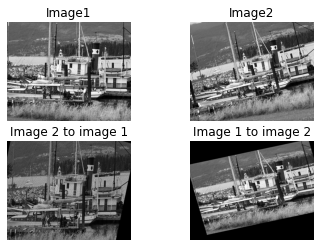

[[[  0.9825206 ]
  [  0.20595484]
  [-23.64873354]]

 [[ -0.20903713]
  [  0.70410572]
  [165.71507161]]]
---Done---


In [71]:
if __name__ == "__main__":
    img = cv2.imread('/home/zhanghh/桌面/Lab4/boat1.pgm')
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    img2 = cv2.imread('/home/zhanghh/桌面/Lab4/boat2.pgm')
    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    
    kp1,kp2,matches = keypoint_match(img,img2)
    best_x = RANSAC(matches, kp1, kp2, 10, 10, 100, img, img2)
    transform_image(img, img2, best_x)
    print("---Done---")

In [110]:
import numpy as np
import cv2 as cv
img = cv.imread('/home/zhanghh/桌面/Lab4/boat1.pgm')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
kp = sift.detect(gray,None)
# img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img=cv.drawKeypoints(gray,kp,img)
cv.imwrite('sift_keypoints.jpg',img)

True

[[1 2 1]
 [3 4 2]
 [2 4 6]]
[[ 1.00000000e+00  1.48029737e-16  2.22044605e-16]
 [ 1.66533454e-16  1.00000000e+00 -5.55111512e-17]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
